In [153]:
import os
import librosa


def getDuration(filename):
    duration = librosa.get_duration(path=filename)
    return duration


ROOT = os.getcwd()

dir = os.path.join(ROOT, "output")

files = sorted(
    [
        (
            int(file.replace(".wav", "")),
            os.path.join(dir, file),
        )
        for file in os.listdir(dir)
        if ".DS_Store" not in file
    ]
)

models = sorted([model for model, filepath in files])

durations_list = [getDuration(filepath) for model, filepath in files]

durations = dict([(model, getDuration(filepath)) for model, filepath in files])

In [154]:
from textwrap import wrap


def lineData(line):
    raw = line.split("INFO: ")[1].replace("[", "").replace("]", "")
    epoch = raw.split(", ")[0].replace(" ", "").split(":")[1].replace(",", "")
    iter = raw.split(", ")[1].replace(" ", "").split(":")[1].replace(",", "")
    meta = {"epoch": int(epoch), "iter": int(iter)}
    rest = list(
        filter(
            None,
            (
                raw.split(", ")[2]
                .replace("(", "")
                .replace(",)", "")
                .replace(": ", ":")
                .split(" ")
            ),
        )
    )
    data = {
        line.split(":")[0]: float(line.split(":")[1])
        for line in rest
        if "lr" not in line.split(":")[0]
    }

    return {**meta, **data}


def logData(filepath):
    log_file = open(filepath).read().splitlines()
    log_lines = [line for line in log_file if "[epoch: " in line]
    data = [lineData(line) for line in log_lines]
    return data


def filterData(data, key):
    filtered = [entry[key] for entry in data]
    return filtered

In [155]:
import os
from matplotlib import pyplot as plt

ROOT = os.getcwd()

logdir = os.path.join(ROOT, "logs")
logfiles = [
    (os.path.join(logdir, file)) for file in os.listdir(logdir) if ".log" in file
]
logfile = logfiles[0]
data = logData(logfile)

modelData = [
    dict(entry, **{"duration": durations[entry["iter"]]})
    for entry in data
    if entry["iter"] in models
]

# loss_text_ce
# loss_mel_ce
# loss_gpt_total

iter = filterData(modelData, "iter")
loss_text_ce = filterData(modelData, "loss_text_ce")
loss_mel_ce = filterData(modelData, "loss_mel_ce")
loss_gpt_total = filterData(modelData, "loss_gpt_total")

In [156]:
len(modelData)

178

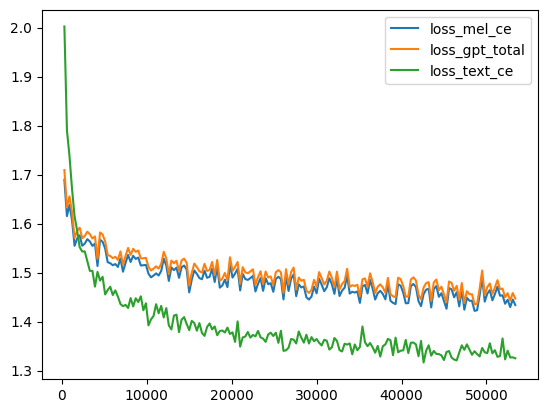

In [157]:
plt.plot(iter, loss_mel_ce, label="loss_mel_ce")
plt.plot(iter, loss_gpt_total, label="loss_gpt_total")
plt.plot(iter, loss_text_ce, label="loss_text_ce")
plt.legend()
plt.show()

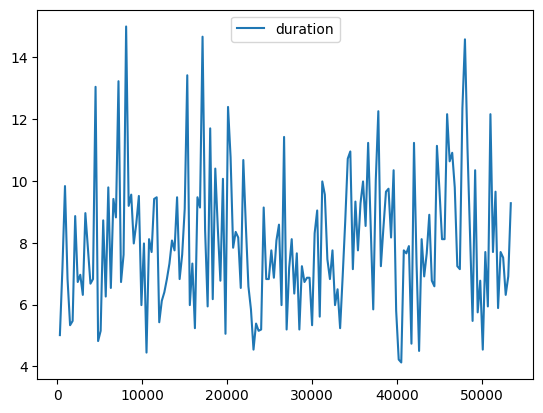

In [158]:
plt.plot(iter, durations_list, label="duration")
plt.legend()
plt.show()

In [159]:
import pandas as pd

results = (
    pd.DataFrame(modelData)
    .query("loss_mel_ce < 1.46")
    .query("duration < 5")
    .sort_values("iter")
)

results

,epoch,iter,step,samples,megasamples,iteration_rate,loss_text_ce,loss_mel_ce,loss_gpt_total,grad_scaler_scale,learning_rate_gpt_0,learning_rate_gpt_1,total_samples_loaded,percent_skipped_samples,percent_conditioning_is_self,gpt_conditioning_encoder,gpt_gpt,gpt_heads,duration
133,1,40200,40200.0,1286400.0,1.2864,0.032024,1.3411,1.4592,1.4727,1.0,0.00001,0.00001,1286400.0,0.11422,0.88578,0.37618,0.28992,0.19431,4.224000
134,1,40500,40500.0,1296000.0,1.2960,0.032281,1.3625,1.4372,1.4508,1.0,0.00001,0.00001,1296000.0,0.11423,0.88577,0.30875,0.31123,0.21540,4.128000
141,1,42600,42600.0,1363200.0,1.3632,0.032703,1.3164,1.4560,1.4692,1.0,0.00001,0.00001,1363200.0,0.11419,0.88581,0.32727,0.29161,0.20111,4.501333
166,2,50100,50100.0,1603200.0,1.6032,0.033126,1.3356,1.4568,1.4702,1.0,0.00001,0.00001,1603200.0,0.11436,0.88564,0.37787,0.33325,0.21329,4.544000


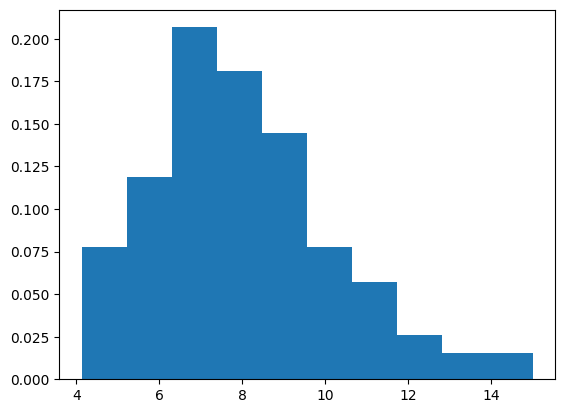

In [160]:
plt.hist(durations_list, density=True, bins=10)
plt.show()

In [141]:
import shutil

os.makedirs("selected", exist_ok=True)

results_list = results["iter"].to_list()

for model, file in files:
    if model in results_list:
        shutil.copyfile(file, file.replace("output", "selected"))